In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
my_path = "drive/My Drive/data/"

# Transformers

Nous utilisons l'architecture Transformer qui est décrite dans ce papier pour la traduction.

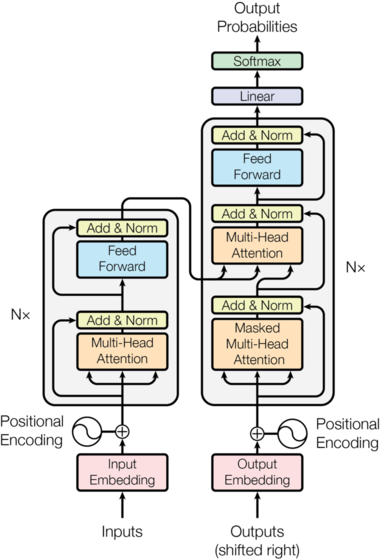

Dans notre cas, nous ferons certaines modifications afin que le modèle transformers soit adapté à la classification. 


 - Seul l'encoder sera utilisé
 - Pas de masques
 - L'attention multi-têtes (Multihead attention) et le FFN (positionwise feedforward network) permettront d'extraire les features
 - Enfin, une couche linéaire pour obtenir le label 




## Préparation des données


In [3]:
import os
import sys
import torch
from torch.nn import functional as F
import numpy as np
from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors, GloVe
import pandas as pd
import torch
from torchtext import data
import spacy
# pour la reproductibilité
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
NLP = spacy.load('en')
tokenizer = lambda sent: [x.text for x in NLP.tokenizer(sent) if x.text != " "]
MAX_SEN_LEN = 200
TEXT = data.Field(sequential=True, tokenize=tokenizer, include_lengths = True,lower=True, fix_length= MAX_SEN_LEN)
LABEL = data.Field(sequential=False, use_vocab=False, dtype = torch.float, pad_token = None, unk_token = None)

train_data, valid_data, test_data = data.TabularDataset.splits(
        path=my_path, train='train.csv',
        validation='valid.csv', test='test.csv', format='csv', skip_header=True,
        fields=[('text', TEXT), ('label', LABEL)])

print(f'Taille des données train: {len(train_data)}')
print(f'Taille des données de validation: {len(valid_data)}')
print(f'Taille des données test: {len(test_data)}')

MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data )

print(f"Nombre de tokens unique dans le TEXT: {len(TEXT.vocab)}") 
print(f"Nombre unique de LABEL: {len(LABEL.vocab)}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 128
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, device = device, sort_key=lambda x: len(x.text), repeat=False, shuffle=True)


Taille des données train: 18163
Taille des données de validation: 2270
Taille des données test: 2271
Nombre de tokens unique dans le TEXT: 25002
Nombre unique de LABEL: 2


## Construire le modèle

On crée une fonction clone qui permet de produire N couches identiques.



In [4]:
# train_utils.py

import torch
from torch import nn
from torch.autograd import Variable
import copy
import math

def clones(module, N):
    "Produit N couches identiques"
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


Les embeddings : chaque mot est représenté par un vecteur (colonne ou ligne de réels), ici de dimension 512, qu'on notera dmodel comme dans le papier "Attention is all you need".


On ajoute ensuite le "positional encoding", qui est une façon d'encoder la place de chaque élément dans la séquence. Comme la longueur des phrases n'est pas prédéterminée, on va utiliser des fonctions sinusoïdales donnant de petites valeurs entre 0 et 1, pour modifier légèrement les embeddings de chaque mot. La dimension de l'embedding de position (à sommer avec l'embedding sémantique du mot) est la même que celle de l'embedding sémantique, soit 512, pour pouvoir sommer terme à terme.

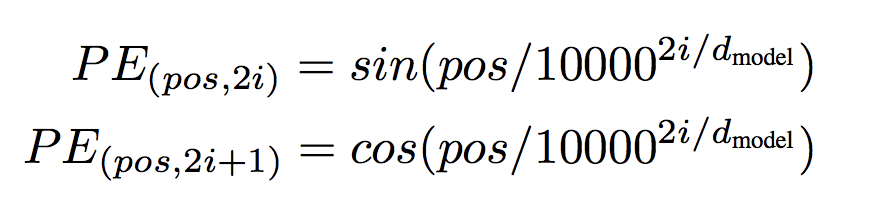


où pos est la position et i la dimension. 




In [5]:
class Embeddings(nn.Module):
    '''
    Couche embedding avec les poids multiplié par sqrt(d_model)
    '''
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)
    

class PositionalEncoding(nn.Module):
    "Fonction PE"
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(torch.as_tensor(position.numpy() * div_term.unsqueeze(0).numpy()))
        pe[:, 1::2] = torch.cos(torch.as_tensor(position.numpy() * div_term.unsqueeze(0).numpy()))#torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

Ensuite nous implémentons les couches LayerNorm et Sublayer.

L'output de chaque sous-couche est **LayerNorm(x+Sublayer(x))**.

On applique un dropout pour l'output de chaque Sublayer avant qu'il soit normalisé.

Toutes les couches du modèle ainsi que les embedding produisent des outputs de dimension **d_model**
.

In [6]:
class LayerNorm(nn.Module):
    "Normalisation"
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2
    
class SublayerOutput(nn.Module):
    '''
    Une connection résiduelle suivie par une couche LayerNorm
    '''
    def __init__(self, size, dropout):
        super(SublayerOutput, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

##Position-wise Feed-Forward Networks


En plus des sous-couches d'attention, chaque couche dans l'encoder contient un fully connected feed-forward network qui est appliqué à chaque position.

Cela consiste en deux transformations linéaires avec une couche d'activation ReLU entre elles. 
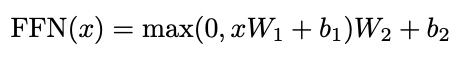



In [7]:
class PositionwiseFeedForward(nn.Module):
    "Positionwise feed-forward network."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        "Implémentation de l'équation FFN ."
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

## Encoder

 - Encoder est composé de N couches identiques
 - Chaque couche a 2 sous-couches : (1) Multi-head attention (2) 2-couches feed-forward network
 - Chaque sous-couche a : (1) Residual (2) Layer normalization 
 - L'output de chaque sous-couche est  LayerNorm(x+Sublayer(x))
 - Dans une couche d'attention, les keys, values et queries proviennent de l'output de la couche précédente dans l'encoder

In [8]:
class Encoder(nn.Module):
    '''
    Transformer Encoder
    
    C'est un ensemble de N couches.
    '''
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)
    
class EncoderLayer(nn.Module):
    '''
    Couche encoder
    '''
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer_output = clones(SublayerOutput(size, dropout), 2)
        self.size = size

    def forward(self, x, mask=None):
        "Transformer Encoder"
        x = self.sublayer_output[0](x, lambda x: self.self_attn(x, x, x, mask)) # Encoder self-attention
        return self.sublayer_output[1](x, self.feed_forward)

## Attention

Chaque mot, décrit comme la somme de ses embeddings sémantiques et positionnels va être décomposé en trois abstractions, :

. Q : Une requête (query)

. K : Une clé (key)

. V : Une valeur (value)

On calcule l'attention à l'aide de la formule suivante : 

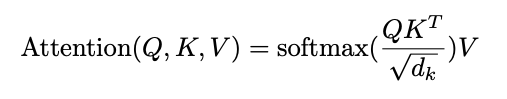

In [9]:
def attention(query, key, value, mask=None, dropout=None):
    "Implementation de la formule de l'attention"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn




Enfin on concatène la sortie de chaque tête, et on multiplie par une matrice W0, de dimensions 512 x 512 ([(nombre de têtes) x (dimension requête ou clé ou valeur, i.e. 64)]x[dimension des embeddings]).

In [10]:

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # on prend d_v = d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Multi-head attention"

        nbatches = query.size(0)
        
        # 1) Projections linéaires dans le batch de d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Appliquer l'attention sur tous les vecteurs projeté dans le batch.
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) Concaténer et appliquer une couche linéaire. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

On a alors le modèle final suivant : 

In [11]:
import numpy as np
from copy import deepcopy
import torch.optim as optim
from torch.nn import functional as F

class Transformer(nn.Module):
    def __init__(self, N, d_model, d_ff, h, dropout,output_size,batch_size, vocab):
        super(Transformer, self).__init__()
        self.N = N

        self.d_model = d_model
        self.d_ff =  d_ff
        self.h = h
        self.dropout = dropout
        self.output_size = output_size
        self.batch_size = batch_size  
        self.vocab = vocab

        h, N, dropout = self.h, self.N, self.dropout
        d_model, d_ff = self.d_model, self.d_ff
        
        attn = MultiHeadedAttention(h, d_model)

        ff = PositionwiseFeedForward(d_model, d_ff, dropout)

        position = PositionalEncoding(d_model, dropout)
        self.encoder = Encoder(EncoderLayer(d_model, deepcopy(attn), deepcopy(ff), dropout), N)
        self.src_embed = nn.Sequential(Embeddings(d_model, self.vocab), deepcopy(position)) #Embeddings suivis par PE

        # Fully-Connected Layer
        self.fc = nn.Linear(
            d_model,
            output_size
        )
        
        # Softmax non-linearity
        self.softmax = nn.Softmax()

    def forward(self, x):
        embedded_sents = self.src_embed(x.permute(1,0)) 
        # embedded_sents [batch_size, sen_len, d_model]
        encoded_sents = self.encoder(embedded_sents)
        # encoded_sents [batch_size, sen_len, d_model]

        final_feature_map = encoded_sents[:,-1,:]
        # final_feature_map[batch_size, d_model]
        final_out = self.fc(final_feature_map)
        return self.softmax(final_out)
    

In [12]:

N = 2 #6 in Transformer Paper
D_MODEL = 256 #512 in Transformer Paper
D_FF = 512 #2048 in Transformer Paper
H = 8
DROPOUT = 0.1
OUTPUT_SIZE = 2




model = Transformer(N, D_MODEL,D_FF, H, DROPOUT,OUTPUT_SIZE,BATCH_SIZE, len(TEXT.vocab))
if torch.cuda.is_available():
  model.cuda()

optimizer = optim.Adam(model.parameters())
criterion = F.cross_entropy # on utilise la loss cross_entropy

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Le modèle a {count_parameters(model):,} paramètres à entraîner')

## Entraînement

In [13]:
def binary_accuracy( preds, y):
  """
  Retourne l'accuracy par batch
  """
  #arrondi la prédiction à l'entier le plus proche
  rounded_preds = torch.round(torch.sigmoid(preds))
  correct = (rounded_preds == y).float() 
  acc = correct.sum() / len(correct)
  return acc

In [14]:
def train_model(model, iterator):
        
  epoch_loss = 0
  epoch_acc = 0

  model.train()
    
  for batch in iterator:
        
    optimizer.zero_grad()
    text = batch.text[0]
            
    target = batch.label 

    if (text.size()[1] is not BATCH_SIZE):
      continue
    predictions = model(text)
     
    target = torch.autograd.Variable(target).long()
    loss = criterion(predictions, target)
    #target = [batch_size]
    #predictions = [batch_size, output_size]
            
    pred = torch.max(predictions, 1)[1].view(target.size()).data
    #pred = [batch_size]
    acc = binary_accuracy(pred.float(), target)

    loss.backward()
        
    optimizer.step()
        
    epoch_loss += loss.item()
    epoch_acc += acc.item()
 
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator):
      
  epoch_loss = 0
  epoch_acc = 0
  model.eval()
      
  with torch.no_grad():    
    for batch in iterator:

      text = batch.text[0]
      if (text.size()[1] is not BATCH_SIZE):
        continue
      target = batch.label 
      predictions = model(text)
      
      target = torch.autograd.Variable(target).long()
      loss = criterion(predictions, target )
      pred = torch.max(predictions, 1)[1].view(target.size()).data
              
      acc = binary_accuracy(pred.float(), target)
          
      epoch_loss += loss.item()
      epoch_acc += acc.item()

  
  return epoch_loss / len(iterator), epoch_acc / len(iterator)     

In [15]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


N_EPOCHS = 20

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train_model(model, train_iterator)
    valid_loss, valid_acc = evaluate(model, valid_iterator)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 01 | Epoch Time: 0m 42s
	Train Loss: 0.651 | Train Acc: 60.04%
	 Val. Loss: 0.566 |  Val. Acc: 65.76%
Epoch: 02 | Epoch Time: 0m 42s
	Train Loss: 0.546 | Train Acc: 74.01%
	 Val. Loss: 0.498 |  Val. Acc: 73.44%
Epoch: 03 | Epoch Time: 0m 42s
	Train Loss: 0.484 | Train Acc: 81.10%
	 Val. Loss: 0.487 |  Val. Acc: 74.48%
Epoch: 04 | Epoch Time: 0m 42s
	Train Loss: 0.451 | Train Acc: 84.84%
	 Val. Loss: 0.470 |  Val. Acc: 76.39%
Epoch: 05 | Epoch Time: 0m 42s
	Train Loss: 0.426 | Train Acc: 87.33%
	 Val. Loss: 0.462 |  Val. Acc: 77.13%
Epoch: 06 | Epoch Time: 0m 42s
	Train Loss: 0.408 | Train Acc: 89.33%
	 Val. Loss: 0.467 |  Val. Acc: 76.65%
Epoch: 07 | Epoch Time: 0m 42s
	Train Loss: 0.396 | Train Acc: 90.51%
	 Val. Loss: 0.458 |  Val. Acc: 77.73%
Epoch: 08 | Epoch Time: 0m 42s
	Train Loss: 0.387 | Train Acc: 91.51%
	 Val. Loss: 0.463 |  Val. Acc: 77.17%
Epoch: 09 | Epoch Time: 0m 42s
	Train Loss: 0.381 | Train Acc: 92.14%
	 Val. Loss: 0.456 |  Val. Acc: 77.99%
Epoch: 10 | Epoch T

## Tester

In [16]:
test_loss, test_acc = evaluate(model, test_iterator)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Test Loss: 0.470 | Test Acc: 76.78%


In [18]:
import spacy
nlp = spacy.load('en')

def predict_sentiment(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.sigmoid(model(tensor))
    out = F.softmax(prediction, 1)

    pred = torch.max(prediction, 1)[1].view(1).data
    if ((pred.item()) == 1):
      print ("Sentiment: Positive")
    else:
      print ("Sentiment: Negative")

predict_sentiment(model, "This film is terrible")


predict_sentiment(model, "This film is great good ")



Sentiment: Negative
Sentiment: Positive


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
